# Next word Prediction using LSTM

### IMPORTING LIBRARIES

In [23]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

### LOAD THE DATA 

In [2]:

data = open("topical_chat_message.txt", "r", encoding = "utf8").read()
print(data[:100])
data = data[:600000]
print(f"length of corpus = {len(data)}")

 Are you a fan of Google or Microsoft?
 Both are excellent technology they are helpful in many ways.
length of corpus = 600000


### DATA PREPROCESSING

In [3]:
# remove sepecial character
data = data.replace('\n','')
data = data.replace('\r','')
data = data.replace('\uefeff','')
data = data.replace('\"','')
data = data.replace('\'','')

#remove extra spaces
data = data.split()
data = " ".join(data)
print(f"Length of corpus is {len(data)} ")

Length of corpus is 589610 


In [4]:
# Tokenization 
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

# save the tokenizer for predicting function in future
pickle.dump(tokenizer, open('tokenizer.pkl','wb'))

In [5]:
 sequence_data = tokenizer.texts_to_sequences([data])[0]
 print(f"length = {len(sequence_data)}")
 print(f"first 5 sequence data = {sequence_data[:5]}")
 size_of_vocab = len(tokenizer.word_index) + 1
 print(f"size_of_vocab={size_of_vocab}")

length = 111828
first 5 sequence data = [19, 6, 3, 133, 7]
size_of_vocab=7764


###  MAKING THE WINDOW FOR RNN(LSTM)

In [6]:
word_length = 3

sequence = []
for i in range( word_length,len(sequence_data)):
  w = sequence_data[i-word_length:i+1] # add one because 0 is used as a pad
  sequence.append(w)
sequence[:5]

[[19, 6, 3, 133],
 [6, 3, 133, 7],
 [3, 133, 7, 238],
 [133, 7, 238, 71],
 [7, 238, 71, 3178]]

In [7]:
# convert to array
sequence = np.array(sequence)

### BREAKING THE DATA TO FEATURES AND LEBEL 

In [8]:
# conver y to categorical
X = []
y = []
for i in sequence:
  X.append(i[0:3])
  y.append(i[3])



### SPLITING DATA FOR TRAINING AND TESTING

In [9]:
# CONVERT TO NP.ARRAY
X = np.array(X)
y = np.array(y)
X_train = X[:590000]
y_train = y[:590000]
X_test = X[590000:]
y_test = y[590000:]

#CONVERT Y TO CATEGORICAL ENCODING 
y_train = to_categorical(y_train,num_classes =  size_of_vocab)
y_test = to_categorical(y_test,num_classes =  size_of_vocab)
y_train[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

## MODEL BUILDING

In [10]:
model = Sequential()
model.add(Embedding(size_of_vocab,10,input_length = 3))
model.add(LSTM(512,return_sequences = True,dropout = 0.2,recurrent_dropout = 0.2))
model.add(LSTM(512,dropout = 0.2,recurrent_dropout = 0.2))
model.add(Dense(512,activation = "relu"))
model.add(Dense(size_of_vocab,activation = "softmax"))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 10)             77640     
                                                                 
 lstm (LSTM)                 (None, 3, 512)            1071104   
                                                                 
 lstm_1 (LSTM)               (None, 512)               2099200   
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 7764)              3982932   
                                                                 
Total params: 7,493,532
Trainable params: 7,493,532
Non-trainable params: 0
_________________________________________________________________


### MODEL COMPILE AND FIT

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001), metrics=['accuracy'])
history = model.fit(X_train,y_train,validation_split=0.05,epochs= 100,batch_size=500).history

Epoch 1/100
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
213/213 [==============================] - ETA: 0s - loss: 6.8170 - accuracy: 0.0356WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x000002800C0C0678> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10

213/213 [==============================] - 107s 503ms/step - loss: 1.5443 - accuracy: 0.5666 - val_loss: 12.7577 - val_accuracy: 0.1665
Epoch 99/100
213/213 [==============================] - 102s 478ms/step - loss: 1.5302 - accuracy: 0.5710 - val_loss: 12.7589 - val_accuracy: 0.1622
Epoch 100/100
213/213 [==============================] - 107s 503ms/step - loss: 1.5227 - accuracy: 0.5710 - val_loss: 12.8894 - val_accuracy: 0.1640


### VISUALIZE MODEL

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### SAVE THE MODEL FOR FUTURE EVOLUTION

In [14]:
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

### PLOT ACCURACY VS VALIDATION ACCURAY 

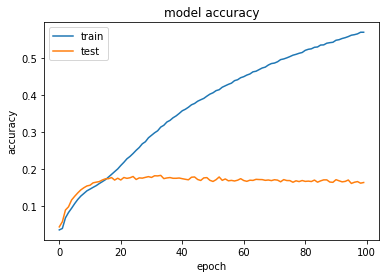

In [15]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

### PLOT LOSS VS VALIDATION LOSS

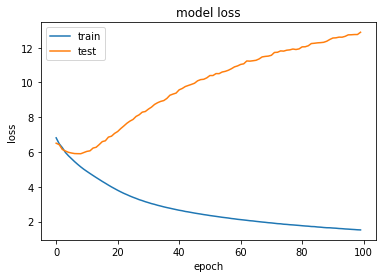

In [16]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

# HYPERPARAMETER TUNNING

### PREAPRE FOR PREDICTING NEXT WORD

In [20]:
# DATA PREPROCESS
def preprocess(data):
    sequence_data = tokenizer.texts_to_sequences([data])  
    return np.array(sequence_data)


### PREDICTING NEXT WORD

In [37]:
def predict(input):
    predicted_word = np.argmax(model.predict(input))
    predicted_word = tokenizer.sequences_to_texts([[predicted_word]])
    return predicted_word


In [ ]:
import warnings
model = load_model('next_word_model.h5')
tokenizer = pickle.load(open('tokenizer.pkl','rb'))
q=True
while(q):
    
    warnings.filterwarnings("ignore")
    ip = input()
    if ip=="bye":
        q=False
    print(predict(preprocess(ip)))